In [ ]:
from loadToSQL import init_spark, load_credentails, set_jdbc_creds
from pyspark.storagelevel import StorageLevel
import pyspark.sql.functions as F

spark = init_spark()
creds = load_credentails()

In [2]:
def run_pushdown_query(stream, creds, query):
    return set_jdbc_creds(stream, creds, None).option('dbtable', query).load()

#### What is the distribution of orders placed on different days of the week?

<Axes: xlabel='order_hour_of_day', ylabel='order_dow'>

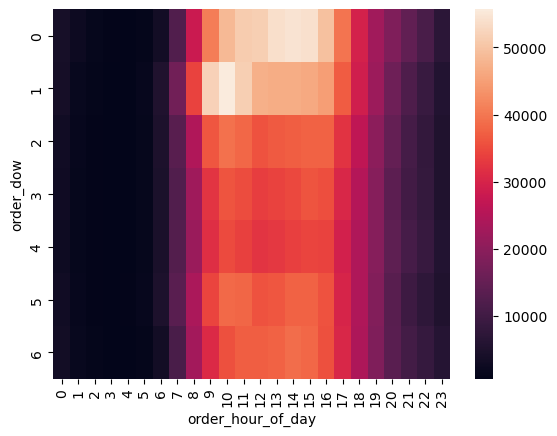

In [3]:
import seaborn as sns

orders = set_jdbc_creds(spark.read, creds, 'orders').load()
res = orders.groupBy(['order_dow', 'order_hour_of_day']).agg(F.count('order_id').alias('count')).orderBy(['order_dow', 'order_hour_of_day']).toPandas()
pivot_df = res.pivot(index='order_dow', columns='order_hour_of_day', values='count')
sns.heatmap(pivot_df)

So, most of orders are in 9-19 hours interval

<Axes: xlabel='order_dow'>

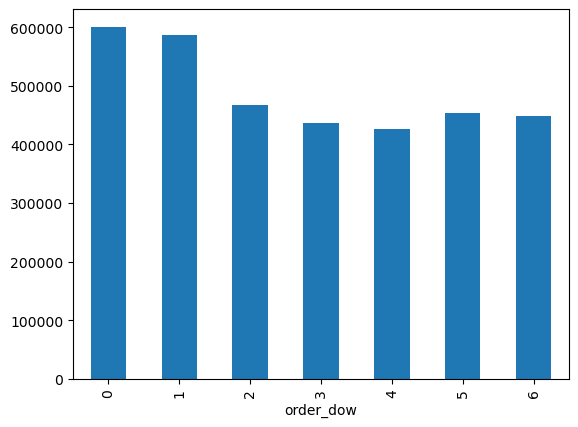

In [4]:
pivot_df.sum(axis=1).plot.bar()

We can map 0 and 1 as Saturday and Sunday respectively based on the assumption that most of the people buy groceries on weekends

#### What are the top 10 product pairs that are most frequently purchased together?

First of all, lets analyze order_id in `order_products__prior` table. It will help us set up partition loading. But before lets explain it

In [5]:
set_jdbc_creds(spark.read, creds, 'order_products__prior').load().agg(F.max('order_id'), F.count('order_id'), F.count_distinct('order_id')).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[], functions=[max(order_id#30), count(order_id#30), count(distinct order_id#30)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=94]
      +- HashAggregate(keys=[], functions=[merge_max(order_id#30), merge_count(order_id#30), partial_count(distinct order_id#30)])
         +- HashAggregate(keys=[order_id#30], functions=[merge_max(order_id#30), merge_count(order_id#30)])
            +- Exchange hashpartitioning(order_id#30, 200), ENSURE_REQUIREMENTS, [plan_id=90]
               +- HashAggregate(keys=[order_id#30], functions=[partial_max(order_id#30), partial_count(order_id#30)])
                  +- Scan JDBCRelation(`instacart`.`order_products__prior`) [numPartitions=1] [order_id#30] PushedFilters: [], ReadSchema: struct<order_id:int>




As we can see, in such scenario it's we must load all data and make different operations, that would be WAY SLOW (i've tried) than if we use push down query. Lets analyze push down query

In [6]:
pushdown_query = '(SELECT MAX(order_id), COUNT(order_id), COUNT(DISTINCT order_id) FROM instacart.order_products__prior) as tmp_tbl'
df = run_pushdown_query(spark.read, creds, pushdown_query)
df.explain()

== Physical Plan ==
*(1) Scan JDBCRelation((SELECT MAX(order_id), COUNT(order_id), COUNT(DISTINCT order_id) FROM instacart.order_products__prior) as tmp_tbl) [numPartitions=1] [MAX(order_id)#59,COUNT(order_id)#60L,COUNT(DISTINCT order_id)#61L] PushedFilters: [], ReadSchema: struct<MAX(order_id):int,COUNT(order_id):bigint,COUNT(DISTINCT order_id):bigint>




So it has only one operation that works very fast on mysql server side. Lets check in code

![](images/sql_query.png)

In [7]:
import time
from contextlib import contextmanager

@contextmanager
def timer():
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.4f} seconds")

with timer():
    order_stat = df.toPandas()
order_stat

Elapsed time: 9.9654 seconds


,MAX(order_id),COUNT(order_id),COUNT(DISTINCT order_id)
0,3421083,32434489,3214874


So, we have equivalent time of execution. And if we need make some operation, that sql server can make faster, we will use it.

Now we will try to answer to the `What are the top 10 product pairs that are most frequently purchased together?`. To count that we firstly group data and collect that on sql server side. And than we use that table to pass to FPGrowth algo.

In [8]:
options = dict(
    lower_bound=0,
    upper_bound=3_500_000, # from order_stat
    num_partitions=50,
    partition_column='order_id',
    # fetch_size=500_000,
)

def read_partitioned_pushdown_query(query, creds, options=options):
    return (
        set_jdbc_creds(spark.read, creds, None)
        .option('dbtable', query)
        .options(**options)
        .load()
    )

pushdown_query = '(SELECT order_id, GROUP_CONCAT(product_id) AS items FROM instacart.order_products__prior GROUP BY order_id) as tmp_tbl'
order_products_items = read_partitioned_pushdown_query(pushdown_query, creds,).persist(StorageLevel.MEMORY_AND_DISK).withColumn('items', F.split('items', ','))
order_products_items.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [order_id#65, split(items#66, ,, -1) AS items#79]
   +- InMemoryTableScan [items#66, order_id#65]
         +- InMemoryRelation [order_id#65, items#66], StorageLevel(disk, memory, 1 replicas)
               +- *(1) Scan JDBCRelation((SELECT order_id, GROUP_CONCAT(product_id) AS items FROM instacart.order_products__prior GROUP BY order_id) as tmp_tbl) [numPartitions=1] [order_id#65,items#66] PushedFilters: [], ReadSchema: struct<order_id:int,items:string>




In [9]:
from pyspark.ml.fpm import FPGrowth
fp = FPGrowth(minSupport=0.01, minConfidence=0.5)
fpm = fp.fit(order_products_items)
df = fpm.freqItemsets.toPandas()


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=21774Kb max_used=21805Kb free=109297Kb
 bounds [0x000000010b1f8000, 0x000000010c768000, 0x00000001131f8000]
 total_blobs=8405 nmethods=7421 adapters=897
 compilation: disabled (not enough contiguous free space left)


25/01/29 19:03:59 WARN MemoryStore: Not enough space to cache rdd_34_0 in memory! (computed 1386.6 MiB so far)
25/01/29 19:03:59 WARN BlockManager: Persisting block rdd_34_0 to disk instead.
25/01/29 19:04:20 WARN MemoryStore: Not enough space to cache rdd_34_0 in memory! (computed 1386.6 MiB so far)
25/01/29 19:04:28 WARN MemoryStore: Not enough space to cache rdd_34_0 in memory! (computed 1386.6 MiB so far)
25/01/29 19:04:41 WARN MemoryStore: Not enough space to cache rdd_34_0 in memory! (computed 1386.6 MiB so far)


In [10]:
df = df.sort_values('freq', ascending=False)
head = df[df['items'].apply(len) > 1]
head

,items,freq
53,"[47209, 13176]",62341
31,"[21137, 13176]",61628
32,"[21137, 24852]",56156
35,"[47766, 24852]",53395
101,"[21903, 24852]",51395
100,"[21903, 13176]",50372
62,"[16797, 24852]",41232
114,"[47626, 24852]",40880
52,"[47209, 21137]",40794
73,"[27966, 13176]",40503


Lets try to know what products they are

In [12]:
products = set_jdbc_creds(spark.read, creds, 'products').load().toPandas().set_index('product_id')
head['items'] = head['items'].apply(lambda lst: [products.loc[int(el), 'product_name'] for el in lst])
head

/var/folders/4v/9k2bzl855819thtr4qn4s7j00000gq/T/ipykernel_20474/23843816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head['items'] = head['items'].apply(lambda lst: [products.loc[int(el), 'product_name'] for el in lst])


,items,freq
53,"[Organic Hass Avocado, Bag of Organic Bananas]",62341
31,"[Organic Strawberries, Bag of Organic Bananas]",61628
32,"[Organic Strawberries, Banana]",56156
35,"[Organic Avocado, Banana]",53395
101,"[Organic Baby Spinach, Banana]",51395
100,"[Organic Baby Spinach, Bag of Organic Bananas]",50372
62,"[Strawberries, Banana]",41232
114,"[Large Lemon, Banana]",40880
52,"[Organic Hass Avocado, Organic Strawberries]",40794
73,"[Organic Raspberries, Bag of Organic Bananas]",40503


So we can conduct, that Vegetables should be kept close together so that a person can immediately take co-ocurring products. Or we can refer to this table, when we wanna to recommend some products to people

In [13]:
# clustering
# predict reordering
# recomendations

#### Clustering 

In [3]:
aisles = """\
(
    SELECT DISTINCT user_id, aisle
    FROM instacart.order_products__prior
        INNER JOIN instacart.products using (product_id)
        INNER JOIN instacart.aisles using (aisle_id)
        INNER JOIN instacart.orders using (order_id)
) as tmp_tbl"""
user_aisle = run_pushdown_query(spark.read, creds, aisles).persist(StorageLevel.MEMORY_AND_DISK)
user_aisle_interaction = (
    user_aisle
        .withColumn('ones', F.lit(1))
        .groupBy('user_id')
        .pivot('aisle')
        .agg({'ones': 'first'})
)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=17300Kb max_used=17413Kb free=113771Kb
 bounds [0x000000010b9f8000, 0x000000010cb18000, 0x00000001139f8000]
 total_blobs=7093 nmethods=6191 adapters=816
 compilation: disabled (not enough contiguous free space left)


In [4]:
from copy import deepcopy
from pyspark.ml.linalg import SparseVector
cols = deepcopy(user_aisle_interaction.columns)
cols.remove('user_id')

def convertToSparse(row):
    notnull = [(i, float(row[col])) for i, col in enumerate(cols) if row[col] is not None]
    return (
        row['user_id'],
        SparseVector(len(cols), notnull)
    )

sparse_user_items = user_aisle_interaction.rdd.map(convertToSparse)
sparse_user_df = spark.createDataFrame(sparse_user_items, ['user_id', 'sparse_items'])

25/02/01 22:21:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
from pyspark.ml.feature import PCA
pca = PCA(k=70, inputCol='sparse_items', outputCol='aisle_pca')
pca_model = pca.fit(sparse_user_df)
print(pca_model.explainedVariance.values.cumsum())
df = pca_model.transform(sparse_user_df)

25/02/01 22:21:42 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 17 (TID 18): Attempting to kill Python Worker
25/02/01 22:21:54 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 27 (TID 33): Attempting to kill Python Worker
25/02/01 22:21:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/02/01 22:22:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


[0.15726479 0.19152136 0.21431394 0.23656057 0.25375952 0.26962415
 0.2844648  0.29815879 0.31117958 0.32363397 0.33567116 0.3473331
 0.3586762  0.36976921 0.38049404 0.3910698  0.40152268 0.41192232
 0.42213478 0.43215153 0.44193831 0.45165404 0.46124784 0.47079006
 0.48021914 0.48959999 0.4988092  0.50789339 0.51692406 0.52585344
 0.53473407 0.54355934 0.55231335 0.5609358  0.56953265 0.5780447
 0.58647424 0.5948296  0.60308545 0.61125773 0.61937752 0.62748229
 0.63555224 0.64346757 0.65129987 0.65908687 0.66681383 0.67443526
 0.68188553 0.68928292 0.69654922 0.70368302 0.7107768  0.71780872
 0.72474959 0.7315555  0.73824866 0.74489514 0.75151514 0.75808157
 0.76447443 0.77078808 0.77699975 0.78313828 0.78914311 0.79500207
 0.80075625 0.80648687 0.81218178 0.81786329]


In [6]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

features_col = "aisle_pca"
evaluator = ClusteringEvaluator(featuresCol=features_col)
km = KMeans(featuresCol=features_col, )

ks = [3, 5, 8, 10, 15, 20]
metrics = []
for k in ks:
    km.setK(k)
    res_df = km.fit(df).transform(df)
    metric = evaluator.evaluate(res_df)
    metrics.append(metric)
    print(k, ':', metric)

3 : 0.1273329649904858


5 : 0.10187286275912256


8 : 0.01524572328300781


10 : 0.017630531587062518


15 : -0.006639413202821593


20 : -0.0163275623388997


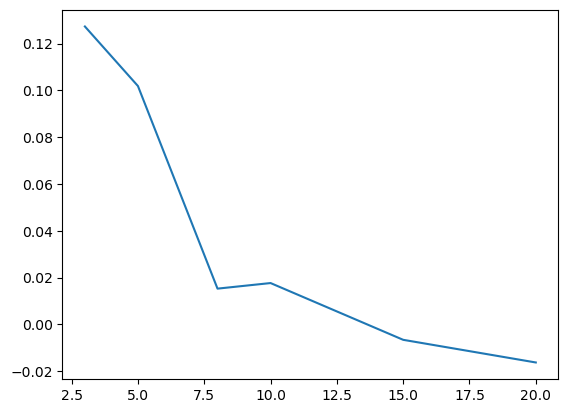

In [7]:
import matplotlib.pyplot as plt
plt.plot(ks, metrics)

As we can see, 10 is best value by Elbow method for clustering. Lets make predictions

In [8]:
km.setK(10)
res_df = km.fit(df).transform(df)
res_df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- sparse_items: vector (nullable = true)
 |-- aisle_pca: vector (nullable = true)
 |-- prediction: integer (nullable = false)



<Axes: xlabel='x', ylabel='y'>

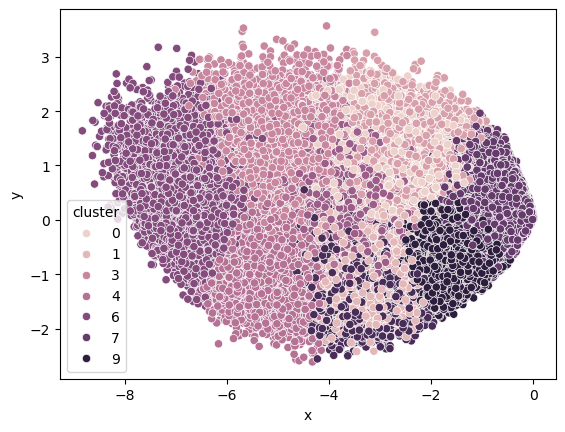

In [12]:
import seaborn as sns
import pandas as pd
pandas_df = res_df.select('aisle_pca', 'prediction').toPandas()
xy = pandas_df['aisle_pca'].apply(lambda x: pd.Series(x[:2], index=['x', 'y'])) # take first two components
xy['cluster'] = pandas_df['prediction']

sns.scatterplot(xy, x='x', y='y', hue='cluster')

Lokks adequate

Lets find products, that we have in every cluster. That products can be every day products

In [13]:
from collections import Counter
from pyspark.sql.types import ArrayType, IntegerType, StructType, StructField

@F.udf(returnType=ArrayType(IntegerType()))
def sparse_indices(sparse_vectors):
    return sparse_vectors.indices.tolist()


agg_schema = ArrayType(StructType([
    StructField("item", IntegerType(), True),
    StructField("count", IntegerType(), True)
]))

@F.udf(returnType=agg_schema)
def agg_top(items, k=20):
    flattened_items = [item for sublist in items for item in sublist]
    return Counter(flattened_items).most_common(k)

cluster_tops = (
    res_df.withColumn('sparse_items', sparse_indices('sparse_items'))
        .groupby('prediction').agg(F.collect_list('sparse_items').alias('all_items'))
        .withColumn('top', agg_top('all_items'))
        .withColumn('top_exploded', F.explode('top'))
        .select('prediction', 'top_exploded.item', 'top_exploded.count')
)

aisles_df = run_pushdown_query(spark.read, creds, '(SELECT * FROM instacart.aisles) as t1')
cluster_tops_names = cluster_tops.withColumnRenamed('item', 'aisle_id').join(aisles_df, 'aisle_id')
cluster_tops_names.groupBy('prediction').agg(F.collect_list('aisle'), F.collect_list('count')).show(truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|prediction|collect_list(aisle)                                                                                                                                                                                                                                                                                                                                                       |collect_list(count)                                                                                         

As we can see, there such products like `fruit vegetable snacks`, `cream` and some others which is exist in every cluster. Lets try filter that, and save only different in tops. And run again

In [14]:
aisles_to_rm = (
    cluster_tops_names
        .groupBy('aisle_id').agg(F.count_distinct('prediction').alias('different_clusters'))
        .filter(F.column('different_clusters') == km.getK())
        .select('aisle_id')
        .rdd.flatMap(lambda x: x)
        .collect()
)

(
    cluster_tops_names
    .filter(~cluster_tops_names['aisle_id'].isin(aisles_to_rm))
    .orderBy('aisle')
    .groupBy('prediction').agg(F.collect_list('aisle'), F.collect_list('count'))
    .show(truncate=False)
)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|prediction|collect_list(aisle)                                                                                                                                                                                                                                                     |collect_list(count)                                                                               |
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
aisles_df.filter(aisles_df['aisle_id'].isin(aisles_to_rm)).show(truncate=False)

+--------+--------------------------+
|aisle_id|aisle                     |
+--------+--------------------------+
|25      |soap                      |
|50      |fruit vegetable snacks    |
|53      |cream                     |
|93      |breakfast bakery          |
|98      |juice nectars             |
|133     |muscles joints pain relief|
+--------+--------------------------+

